In [1]:
import pandas as pd
summary_50_train_x_df = pd.read_parquet("df/summary_50_train_df_x.gzip")
summary_100_train_x_df = pd.read_parquet("df/summary_100_train_df_x.gzip")
text_train_x_df = pd.read_parquet("df/text_train_df_x.gzip")

In [52]:
import numpy as np

def top_k_feature_details_per_class(shap_values, feature_names, k=10):
    """
    Return top-k features and their contributions for each class.

    Args:
        shap_values (np.ndarray): shape (n_samples, n_features, n_classes)
        feature_names (list): feature names
        k (int): number of top features to extract

    Returns:
        dict: keys are class indices, values are DataFrames with top-k features
    """
    n_classes = shap_values.shape[2]
    abs_mean_shap = np.abs(shap_values).mean(axis=0)  # shape: (n_features, n_classes)

    result = {}

    for c in range(n_classes):
        shap_c = abs_mean_shap[:, c]
        top_k_idx = np.argsort(shap_c)[-k:][::-1]  # descending order
        top_k_feats = [feature_names[i] for i in top_k_idx]
        top_k_vals = shap_c[top_k_idx]
        total = shap_c.sum()
        percent_contrib = 100 * top_k_vals / total

        df = pd.DataFrame({
            "feature": top_k_feats,
            "mean_abs_shap": top_k_vals,
            "percent_of_total": percent_contrib
        })
        result[c] = df.to_dict()

    return result

In [ ]:
import joblib

shap_values = joblib.load("results/shap/shap_explanations/shap_explanation_text_sentiment.pkl")

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [5]:
import numpy as np
subset_importance_sum = np.abs(shap_values).sum()

In [7]:
subset_sum_per_class = np.abs(shap_values).sum(axis=(0, 1))

In [3]:
print(shap_values.shape)

(36071, 2445, 3)


In [63]:
sentiment_indices = [col for i, col in enumerate(text_train_x_df.columns) if col.startswith("sentiment")]

In [64]:
print(len(sentiment_indices))

2445


In [65]:
dct = top_k_feature_details_per_class(shap_values, sentiment_indices)

In [66]:
dct

{0: {'feature': {0: 'sentiment Supreme Court',
   1: 'sentiment Free Speech',
   2: 'sentiment Bernie Sanders',
   3: 'sentiment Donald Trump',
   4: 'sentiment Campaign Finance',
   5: 'sentiment Politics',
   6: 'sentiment LGBTQ Issues',
   7: 'sentiment Nuclear Weapons',
   8: 'sentiment Pentagon',
   9: 'sentiment Immigration'},
  'mean_abs_shap': {0: 0.0012668264098465443,
   1: 0.0010300562717020512,
   2: 0.0005588869098573923,
   3: 0.0003218822821509093,
   4: 0.0003192909643985331,
   5: 0.00029948638984933496,
   6: 0.00025102178915403783,
   7: 0.00021148563246242702,
   8: 0.00018709548749029636,
   9: 0.0001822901685955003},
  'percent_of_total': {0: 23.820091247558594,
   1: 19.36811065673828,
   2: 10.508729934692383,
   3: 6.052340984344482,
   4: 6.003616809844971,
   5: 5.631231784820557,
   6: 4.719953536987305,
   7: 3.9765565395355225,
   8: 3.517949342727661,
   9: 3.427595376968384}},
 1: {'feature': {0: 'sentiment US House',
   1: 'sentiment Violence In America

In [67]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_percent_shap_bar(top_k_dict, top_n=10):
    # Flatten the nested dict
    records = []
    for cls, data in top_k_dict.items():
        for i in range(len(data['feature'])):
            records.append({
                "class": cls,
                "feature": data['feature'][i],
                "percent": data['percent_of_total'][i]
            })
    df = pd.DataFrame(records)

    # Keep only top N features per class
    df_top = df.groupby('class').apply(lambda g: g.nlargest(top_n, 'percent')).reset_index(drop=True)

    # Normalize feature names for axis legibility
    df_top['short_feature'] = df_top['feature'].str.replace('sentiment ', '').str.wrap(15)

    # Pivot to plot
    pivot_df = df_top.pivot(index='short_feature', columns='class', values='percent').fillna(0)

    # Sort features by average importance
    pivot_df = pivot_df.loc[pivot_df.mean(axis=1).sort_values(ascending=False).index]

    # Plot
    pivot_df.plot(kind='bar', figsize=(12, 6))
    plt.ylabel("Percent of Total SHAP Importance")
    plt.title(f"Full Text: Top {top_n} Feature Contributions per Class")
    plt.xlabel("Top Features")
    plt.xticks(rotation=45, ha='right')
    plt.legend(title="Class")
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.savefig("results/shap/plots/text_top_10.png")
    plt.show()

/var/folders/fz/y03qr7rx39zcncb4x6fsnclm0000gn/T/ipykernel_38304/108390496.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_top = df.groupby('class').apply(lambda g: g.nlargest(top_n, 'percent')).reset_index(drop=True)


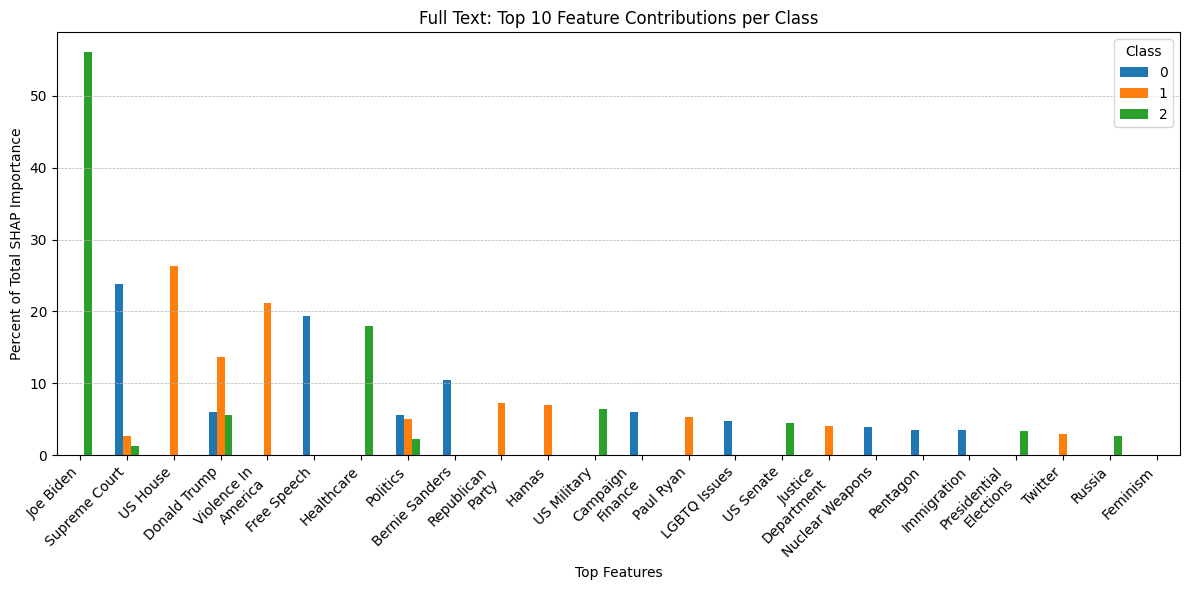

In [68]:
plot_percent_shap_bar(dct)